# 8.01~8.04 알렉스넷 모델 실습

In [ ]:
pip install torchinfo

In [ ]:
from torchvision import models
from torchinfo import summary

# Pre-trained AlexNet 모델을 로드함
model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")

# 모델의 구조와 각 계층의 파라미터 개수를 요약해서 출력함
summary(model, (1, 3, 224, 224), device="cpu")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 44.1MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [ ]:
import requests

# 데이터셋 URL과 저장 경로 지정
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
save_path = "/content/drive/MyDrive/GDG - study/imagenet_classes.txt"

# 데이터 다운로드 및 저장
response = requests.get(url)
if response.status_code == 200:
    with open(save_path, "w") as file:
        file.write(response.text)
    print(f"파일이 성공적으로 저장되었습니다: {save_path}")
else:
    print(f"다운로드 실패: {response.status_code}")

파일이 성공적으로 저장되었습니다: /content/drive/MyDrive/GDG - study/imagenet_classes.txt


In [ ]:
# ImageNet 클래스 레이블 파일을 읽어서 리스트로 저장함
with open("/content/drive/MyDrive/GDG - study/imagenet_classes.txt", "r") as file:
    classes = file.read().splitlines()

# 클래스 레이블 총 개수와 첫 번째 클래스 레이블을 출력함
print(f"클래스 개수 : {len(classes)}")
print(f"첫 번째 클래스 레이블 : {classes[0]}")

클래스 개수 : 1000
첫 번째 클래스 레이블 : tench


In [ ]:
import torch
from PIL import Image
from torchvision import models, transforms

# 입력 이미지를 전처리하기 위한 변환 정의
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 조정함
        transforms.ToTensor(),  # 이미지를 텐서로 변환함
        transforms.Normalize(  # ImageNet 데이터셋의 평균과 표준편차로 정규화함
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

# 모델을 실행할 디바이스를 선택함 (GPU가 있으면 cuda, 없으면 cpu 사용)
device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델을 평가 모드로 설정하고 선택된 디바이스에 로드함
model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1").eval().to(device)

In [ ]:
# 추론에 사용할 이미지 텐서를 저장할 리스트를 초기화함
tensors = []
files = [
    "/content/drive/MyDrive/GDG - study/images/airplane.jpg",
    "/content/drive/MyDrive/GDG - study/images/bus.jpg"
]

# 각 이미지 파일에 대해 전처리 수행
for file in files:
    image = Image.open(file)  # 이미지를 열고
    tensors.append(transform(image))  # 변환을 적용한 결과를 리스트에 추가함

# 리스트에 있는 이미지를 하나의 텐서로 스택함
tensors = torch.stack(tensors)
print(f"입력 텐서의 크기 : {tensors.shape}")  # 입력 텐서의 크기를 출력함

입력 텐서의 크기 : torch.Size([2, 3, 224, 224])


In [ ]:
import numpy as np
from torch.nn import functional as F

# 추론 수행 (기울기 계산 비활성화)
with torch.no_grad():
    outputs = model(tensors.to(device))  # 모델에 입력 텐서를 전달하여 출력을 얻음
    probs = F.softmax(outputs, dim=-1)  # 출력 값에 소프트맥스 함수 적용하여 확률 계산
    top_probs, top_idxs = probs.topk(5)  # 상위 5개의 클래스 확률과 인덱스를 반환함

# GPU에서 CPU로 데이터를 이동하고 넘파이 배열로 변환함
top_probs = top_probs.detach().cpu().numpy()
top_idxs = top_idxs.detach().cpu().numpy()
top_classes = np.array(classes)[top_idxs]  # 클래스 인덱스를 클래스 이름으로 변환함

# 각 이미지 파일에 대해 추론 결과 출력
for idx, (cls, prob) in enumerate(zip(top_classes, top_probs)):
    print(f"{files[idx]} 추론 결과")  # 이미지 파일 경로 출력
    for c, p in zip(cls, prob):  # 각 클래스와 확률 쌍을 출력함
        print(f" - {c:<30} : {p * 100:>5.2f}%")

/content/drive/MyDrive/GDG - study/images/airplane.jpg 추론 결과
 - airliner                       : 97.84%
 - wing                           :  1.89%
 - airship                        :  0.22%
 - warplane                       :  0.03%
 - space shuttle                  :  0.02%
/content/drive/MyDrive/GDG - study/images/bus.jpg 추론 결과
 - trolleybus                     : 67.70%
 - passenger car                  : 23.38%
 - minibus                        :  3.42%
 - electric locomotive            :  1.39%
 - streetcar                      :  1.09%


# 예제 8.05~8.06 데이터 시각화

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

# 하이퍼파라미터 설정
hyperparams = {
    "batch_size": 4,  # 한 번에 처리할 데이터 샘플의 수
    "learning_rate": 0.0001,  # 학습률
    "epochs": 5,  # 학습 반복 횟수 (에포크)
    "transform": transforms.Compose(  # 데이터 전처리 파이프라인 정의
        [
            transforms.Resize(256),  # 이미지를 256x256 크기로 리사이즈
            transforms.CenterCrop(224),  # 중심에서 224x224로 크롭
            transforms.ToTensor(),  # 이미지를 텐서로 변환 (0~255 → 0~1 정규화)
            transforms.Normalize(  # 이미지 정규화 (평균과 표준편차로 정규화)
                mean=[0.48235, 0.45882, 0.40784],  # RGB 평균값
                std=[1.0/255.0, 1.0/255.0, 1.0/255.0]  # RGB 표준편차
            )
        ]
    )
}

### 데이터 저장

In [ ]:
# Google Drive 연결
from google.colab import drive
drive.mount('/content/drive')

# 데이터 다운로드
!wget -P /content/drive/MyDrive/GDG-datasets/ https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget -P /content/drive/MyDrive/GDG-datasets/ https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

# 데이터 압축 해제
!tar -xvzf /content/drive/MyDrive/GDG-datasets/images.tar.gz -C /content/drive/MyDrive/GDG-datasets/
!tar -xvzf /content/drive/MyDrive/GDG-datasets/annotations.tar.gz -C /content/drive/MyDrive/GDG-datasets/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 원본 데이터 경로
images_path = "/content/drive/MyDrive/GDG-datasets/images/"
train_path = "/content/drive/MyDrive/GDG-datasets/pet/train/"
test_path = "/content/drive/MyDrive/GDG-datasets/pet/test/"

# 디렉토리 생성
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# 모든 이미지 파일 리스트
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

# Train-Test 분리
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

# 이미지 이동
for file in train_files:
    label = "cat" if "cat" in file.lower() else "dog"
    os.makedirs(os.path.join(train_path, label), exist_ok=True)
    shutil.move(os.path.join(images_path, file), os.path.join(train_path, label, file))

for file in test_files:
    label = "cat" if "cat" in file.lower() else "dog"
    os.makedirs(os.path.join(test_path, label), exist_ok=True)
    shutil.move(os.path.join(images_path, file), os.path.join(test_path, label, file))

In [ ]:
# 학습 데이터셋 로드
# 테스트 데이터셋 로드
train_dataset = ImageFolder("/content/drive/MyDrive/GDG-datasets/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/drive/MyDrive/GDG-datasets/pet/test", transform=hyperparams["transform"])


# 학습 데이터 로더 생성
train_dataloader = DataLoader(
    train_dataset,  # 학습 데이터셋
    batch_size=hyperparams["batch_size"],  # 배치 크기 설정
    shuffle=True,  # 데이터를 랜덤하게 섞음
    drop_last=True  # 배치에서 남는 데이터를 버림
)

# 테스트 데이터 로더 생성
test_dataloader = DataLoader(
    test_dataset,  # 테스트 데이터셋
    batch_size=hyperparams["batch_size"],  # 배치 크기 설정
    shuffle=True,  # 데이터를 랜덤하게 섞음
    drop_last=True  # 배치에서 남는 데이터를 버림
)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# 이미지 정규화 해제를 위한 평균과 표준편차 설정
mean = [0.48235, 0.45882, 0.40784]  # 정규화에 사용된 RGB 평균값
std = [1.0/255.0, 1.0/255.0, 1.0/255.0]  # 정규화에 사용된 RGB 표준편차

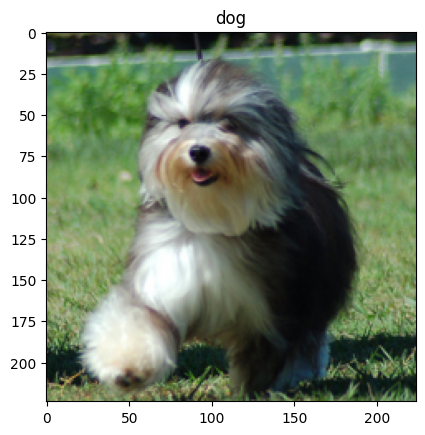

In [ ]:
# 학습 데이터 배치에서 첫 번째 배치를 가져옴
images, labels = next(iter(train_dataloader))

# 이미지와 레이블을 순차적으로 확인
for image, label in zip(images, labels):
    # 텐서를 numpy 배열로 변환하고 채널 순서 변경 (C, H, W → H, W, C)
    image = image.numpy().transpose((1, 2, 0))

    # 정규화 해제 및 픽셀 값을 0~255 범위로 변환
    image = ((std * image + mean) * 255).astype(np.uint8)

    # 이미지를 시각화
    plt.imshow(image)  # 이미지를 표시
    plt.title(train_dataset.classes[int(label)])  # 이미지의 클래스 이름 표시
    plt.show()  # 그래프 표시

    break  # 첫 번째 이미지만 확인 후 반복 종료

# 예제 8.07~8.09 VGG-16 모델 실습

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

# 하이퍼파라미터 설정
hyperparams = {
    "batch_size": 4,  # 한 번에 처리할 데이터 샘플 수
    "learning_rate": 0.0001,  # 학습률
    "epochs": 5,  # 학습 반복 횟수
    "transform": transforms.Compose(  # 데이터 전처리 정의
        [
            transforms.Resize(256),  # 이미지 크기를 256x256으로 조정
            transforms.CenterCrop(224),  # 중심에서 224x224로 크롭
            transforms.ToTensor(),  # 이미지를 텐서로 변환
            transforms.Normalize(  # 정규화 수행
                mean=[0.48235, 0.45882, 0.40784],  # RGB 평균
                std=[1.0 / 255.0, 1.0 / 255.0, 1.0 / 255.0],  # RGB 표준편차
            ),
        ]
    ),
}

In [ ]:
# 학습 및 테스트 데이터셋 로드 (ImageFolder 구조 사용)
train_dataset = ImageFolder("/content/drive/MyDrive/GDG-datasets/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/drive/MyDrive/GDG-datasets/pet/test", transform=hyperparams["transform"])

# 데이터로더 정의
train_dataloader = DataLoader(
    train_dataset,  # 학습 데이터셋
    batch_size=hyperparams["batch_size"],  # 배치 크기
    shuffle=True,  # 데이터를 랜덤하게 섞음
    drop_last=True,  # 남은 데이터를 버림
)
test_dataloader = DataLoader(
    test_dataset,  # 테스트 데이터셋
    batch_size=hyperparams["batch_size"],  # 배치 크기
    shuffle=True,  # 데이터를 랜덤하게 섞음
    drop_last=True,  # 남은 데이터를 버림
)

In [ ]:
# Pre-trained VGG16 모델 로드
# 세 번째 코드: 모델 정의 및 수정
model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")

# VGG16의 마지막 Fully Connected Layer를 현재 데이터셋의 클래스 수에 맞게 변경
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델을 디바이스로 이동
model = model.to(device)


In [ ]:
# 손실 함수 정의
# 네 번째 코드: 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss().to(device)

# 최적화 알고리즘 정의 (SGD 사용)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])


In [ ]:
# 학습 루프
# 다섯 번째 코드: 모델 학습 루프
for epoch in range(hyperparams["epochs"]):  # 설정된 에포크 수만큼 반복
    cost = 0.0  # 에포크별 총 손실 초기화

    for images, classes in train_dataloader:  # 배치 단위로 데이터 로드
        images = images.to(device)  # 이미지를 디바이스로 이동
        classes = classes.to(device)  # 레이블을 디바이스로 이동

        output = model(images)  # 모델에 이미지 입력하여 예측값 얻기
        loss = criterion(output, classes)  # 손실 계산

        optimizer.zero_grad()  # 이전 단계의 기울기 초기화
        loss.backward()  # 역전파 수행
        optimizer.step()  # 가중치 업데이트

        cost += loss  # 배치별 손실 누적

    cost = cost / len(train_dataloader)  # 에포크별 평균 손실 계산
    print(f"Epoch : {epoch + 1:4d}, Cost : {cost:.3f}")  # 에포크 진행 상황 출력

Epoch :    1, Cost : 0.000
Epoch :    2, Cost : 0.000
Epoch :    3, Cost : 0.000
Epoch :    4, Cost : 0.000
Epoch :    5, Cost : 0.000


In [ ]:
# 테스트 루프
# 여섯 번째 코드: 모델 평가 (테스트 데이터셋)
with torch.no_grad():  # 기울기 계산 비활성화 (추론 단계)
    model.eval()  # 모델을 평가 모드로 전환

    accuracy = 0.0  # 정확도 초기화
    for images, classes in test_dataloader:  # 테스트 데이터 로더에서 데이터 로드
        images = images.to(device)  # 이미지를 디바이스로 이동
        classes = classes.to(device)  # 레이블을 디바이스로 이동

        outputs = model(images)  # 모델에 이미지 입력하여 예측값 얻기
        probs = F.softmax(outputs, dim=-1)  # 확률 값으로 변환
        outputs_classes = torch.argmax(probs, dim=-1)  # 가장 높은 확률의 클래스 선택

        accuracy += int(torch.eq(classes, outputs_classes).sum())  # 정확히 예측한 샘플 수 누적

    # 정확도를 전체 샘플 수로 나누어 백분율로 출력
    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")

acc@1 : 100.00%


In [ ]:
import os

# 저장 경로 설정
save_dir = "../models/"
os.makedirs(save_dir, exist_ok=True)  # 디렉토리를 생성 (이미 존재하면 무시)

# 모델 가중치 저장
torch.save(model.state_dict(), os.path.join(save_dir, "VGG16.pt"))
print("Saved the model weights")

Saved the model weights


# 예제 8.10~8.13 레즈넷 모델 구현

In [ ]:
from torch import nn

# BasicBlock 정의 (ResNet의 기본 구성 블록)
class BasicBlock(nn.Module):
    expansion = 1  # 출력 채널 확장 비율

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        # 첫 번째 3x3 컨볼루션 계층
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)  # 배치 정규화
        self.relu = nn.ReLU(inplace=True)  # 활성화 함수
        # 두 번째 3x3 컨볼루션 계층
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)  # 배치 정규화

        # Shortcut 연결 정의
        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion * planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        # 메인 경로 연산
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Shortcut 연결
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
# BottleneckBlock 정의 (ResNet의 Bottleneck 구성 블록)
class BottleneckBlock(nn.Module):
    expansion = 4  # 출력 채널 확장 비율

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        # 첫 번째 1x1 컨볼루션 계층
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        # 두 번째 3x3 컨볼루션 계층
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # 세 번째 1x1 컨볼루션 계층
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        self.relu = nn.ReLU(inplace=True)

        # Shortcut 연결 정의
        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion * planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        # 메인 경로 연산
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        # Shortcut 연결
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
import torch

# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.inplanes = 64  # 초기 입력 채널 수
        # 초기 Stem 정의 (입력 이미지 처리 단계)
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # Stage 1 ~ 4 구성
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)
        # 평균 풀링과 최종 Fully Connected 계층
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    # ResNet Stage 생성을 위한 헬퍼 함수
    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        # ResNet의 순전파 정의
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)  # 평탄화
        out = self.fc(out)
        return out

In [ ]:
from torchvision import models
from torchinfo import summary

# 다양한 ResNet 버전 생성
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)  # ResNet-18
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)  # ResNet-34
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 1000)  # ResNet-50
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 1000)  # ResNet-101
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 1000)  # ResNet-152

# PyTorch의 Pre-trained ResNet34 로드
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

# 커스텀 ResNet-34와 PyTorch 모델의 파라미터 개수 비교
resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

# 총 파라미터 개수 출력
print(resnet34_info.total_params)  # 커스텀 모델 파라미터
print(torch_model_info.total_params)  # PyTorch 모델 파라미터

21797672
21797672


# 예제 8.14~8.17 클래스 활성화 맵 실습

In [ ]:
from torch import nn
from torchvision import models

# Pre-trained ResNet18 모델을 로드하고 평가 모드로 설정
model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval()

# ResNet18의 마지막 두 계층(fc와 avgpool)을 제거하고 특징 추출 부분만 사용
features = nn.Sequential(*list(model.children())[:-2])

In [ ]:
from PIL import Image
from torchvision import transforms

# 이미지 전처리를 위한 Transform 정의
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # 이미지를 224x224로 크기 조정
        transforms.ToTensor(),  # 이미지를 텐서로 변환
        transforms.Normalize(  # ImageNet 데이터셋의 평균과 표준편차로 정규화
            mean=[0.485, 0.456, 0.406],  # RGB 채널별 평균값
            std=[0.229, 0.224, 0.225]   # RGB 채널별 표준편차
        ),
    ]
)

# 이미지를 로드하고 전처리 적용
image = Image.open("/content/drive/MyDrive/GDG - study/images/airplane.jpg")  # 입력 이미지 로드
target = transform(image).unsqueeze(0)  # 배치 차원을 추가 (1, 3, 224, 224)

In [ ]:
# 모델에 입력 이미지를 전달하여 클래스 예측
output = model(target)  # 모델의 출력 (클래스 점수)
class_idx = int(output.argmax())  # 가장 높은 클래스 점수의 인덱스 추출

# 해당 클래스의 Fully Connected Layer의 가중치 가져오기
weights = model.fc.weight[class_idx].reshape(-1, 1, 1)  # 가중치를 (C, 1, 1) 형태로 변환

# 특징 맵을 추출하기 위해 ResNet의 마지막 Conv 레이어 출력
features_output = features(target).squeeze()  # (C, H, W) 형태로 변환

In [ ]:
# 출력 형상 확인
print(weights.shape)  # (512, 1, 1) - 클래스에 대한 가중치
print(features_output.shape)  # (512, 7, 7) - 특징 맵 크기

torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


In [ ]:
import torch
from torch.nn import functional as F

# Class Activation Map(CAM)을 생성
cam = features_output * weights  # 클래스별 가중치와 특징 맵을 곱함
cam = torch.sum(cam, dim=0)  # 채널 축(C)을 따라 합산하여 최종 CAM 생성

# CAM 크기를 원래 이미지 크기로 보간
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0),  # (H, W) → (1, 1, H, W)
    size=(image.size[1], image.size[0]),  # 원래 이미지 크기 (높이, 너비)
    mode="bilinear",  # 양선형 보간 사용
).squeeze().detach().numpy()  # 결과를 numpy 배열로 변환

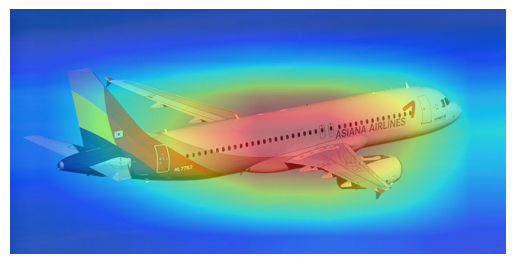

In [ ]:
import matplotlib.pyplot as plt

# 원본 이미지에 CAM을 오버레이하여 시각화
plt.imshow(image)  # 원본 이미지 표시
plt.imshow(cam, cmap="jet", alpha=0.5)  # CAM을 "jet" 컬러맵으로 표시 (alpha로 투명도 설정)
plt.axis("off")  # 축 제거
plt.show()  # 그래프 출력

# 예제 8.18~8.20 Grad-CAM 실습

In [ ]:
import torch

# GradCAM 클래스 정의
class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()  # 모델을 평가 모드로 설정
        self.register_hook(main, sub)  # 지정된 모듈에 Hook을 등록

    # Grad-CAM에 필요한 Hook을 등록하는 메서드
    def register_hook(self, main, sub):
        for name, module in self.model.named_children():  # 모델의 상위 모듈 반복
            if name == main:  # 지정된 Main 모듈을 찾음
                for sub_name, sub_module in module[-1].named_children():  # 하위 모듈 반복
                    if sub_name == sub:  # 지정된 Sub 모듈을 찾음
                        sub_module.register_forward_hook(self.forward_hook)  # Forward Hook 등록
                        sub_module.register_full_backward_hook(self.backward_hook)  # Backward Hook 등록

    # Forward Hook: Forward 과정에서 특징 맵을 저장
    def forward_hook(self, module, input, output):
        self.feature_map = output  # Forward에서 나온 출력(특징 맵)을 저장

    # Backward Hook: Backward 과정에서 Gradient를 저장
    def backward_hook(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]  # Backward에서 나온 Gradient를 저장

    # Grad-CAM 생성 메서드
    def __call__(self, x):
        output = self.model(x)  # 모델에 입력 데이터를 전달

        index = output.argmax(axis=1)  # 각 샘플별로 가장 높은 클래스 인덱스 추출
        one_hot = torch.zeros_like(output)  # One-hot 벡터 생성
        for i in range(output.size(0)):
            one_hot[i][index[i]] = 1  # 해당 클래스에만 1 설정

        self.model.zero_grad()  # 기울기를 초기화
        output.backward(gradient=one_hot, retain_graph=True)  # One-hot 벡터로 역전파 수행

        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True)  # 채널별 평균 Gradient 계산
        grad_cam = torch.sum(a_k * self.feature_map, dim=1)  # 가중치 * 특징 맵의 합산으로 Grad-CAM 생성
        grad_cam = torch.relu(grad_cam)  # ReLU를 적용하여 음수 값을 제거
        return grad_cam  # 생성된 Grad-CAM 반환

In [ ]:
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt

# 데이터 전처리 Transform 정의
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # 이미지를 224x224로 리사이즈
        transforms.ToTensor(),  # 이미지를 Tensor로 변환
        transforms.Normalize(  # ImageNet 데이터셋의 평균과 표준편차로 정규화
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

# 사용할 이미지 파일 리스트 정의
files = [
    "../content/drive/MyDrive/GDG - study/images/airplane.jpg", "../content/drive/MyDrive/GDG - study/images/bus.jpg"]


# 이미지를 저장할 리스트 및 전처리된 텐서를 저장할 리스트 초기화
images, tensors = [], []
for file in files:  # 파일 리스트를 순회하며
    image = Image.open(file)  # 이미지를 열고
    images.append(image)  # 원본 이미지를 리스트에 추가
    tensors.append(transform(image))  # 전처리를 적용한 텐서를 리스트에 추가
tensors = torch.stack(tensors)  # 텐서를 하나의 배치로 묶음 (B, C, H, W)

In [ ]:
# Grad-CAM 모델 생성
model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),  # Pre-trained ResNet18 사용
    main="layer4",  # Grad-CAM을 적용할 Main 모듈
    sub="conv2"  # Grad-CAM을 적용할 Sub 모듈
)

# Grad-CAM 생성
grad_cams = model(tensors)  # 입력 데이터로 Grad-CAM 계산

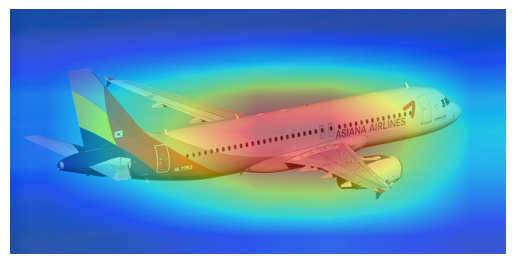

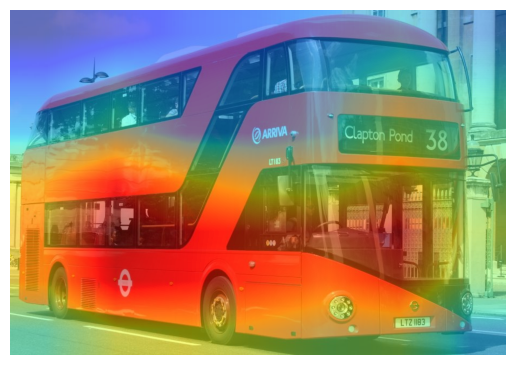

In [ ]:
for idx, image in enumerate(images):  # 각 이미지와 Grad-CAM을 순회
    # Grad-CAM을 원본 이미지 크기로 보간
    grad_cam = F.interpolate(
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0),  # Grad-CAM을 (1, 1, H, W)로 확장
        size=(image.size[1], image.size[0]),  # 원본 이미지 크기
        mode="bilinear",  # 양선형 보간 사용
    ).squeeze().detach().numpy()  # 최종적으로 Numpy 배열로 변환

    # Grad-CAM을 원본 이미지 위에 오버레이
    plt.imshow(image)  # 원본 이미지 표시
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)  # Grad-CAM 오버레이 (jet 컬러맵, 50% 투명도)
    plt.axis("off")  # 축 제거
    plt.show()  # Grad-CAM 결과 출력